In [1]:
#! pip install geomap
# ! pip install geopandas

In [2]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import statsmodels.api as sm
import geopandas as gpd
import re

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importing the data in a variable with Pandas read_csv method.
real_estate_data=pd.read_csv("train.csv")

In [4]:
#checking the shape of the data
real_estate_data.shape

(27321, 80)

#### We have about 27321 records/observation and 80 features.

In [5]:
# checking the first five rows of the data
real_estate_data.head()

,UID,BLOCKID,SUMLEVEL,COUNTYID,STATEID,state,state_ab,city,place,type,...,female_age_mean,female_age_median,female_age_stdev,female_age_sample_weight,female_age_samples,pct_own,married,married_snp,separated,divorced
0,267822,NaN,140,53,36,New York,NY,Hamilton,Hamilton,City,...,44.48629,45.33333,22.51276,685.33845,2618.0,0.79046,0.57851,0.01882,0.01240,0.08770
1,246444,NaN,140,141,18,Indiana,IN,South Bend,Roseland,City,...,36.48391,37.58333,23.43353,267.23367,1284.0,0.52483,0.34886,0.01426,0.01426,0.09030
2,245683,NaN,140,63,18,Indiana,IN,Danville,Danville,City,...,42.15810,42.83333,23.94119,707.01963,3238.0,0.85331,0.64745,0.02830,0.01607,0.10657
3,279653,NaN,140,127,72,Puerto Rico,PR,San Juan,Guaynabo,Urban,...,47.77526,50.58333,24.32015,362.20193,1559.0,0.65037,0.47257,0.02021,0.02021,0.10106
4,247218,NaN,140,161,20,Kansas,KS,Manhattan,Manhattan City,City,...,24.17693,21.58333,11.10484,1854.48652,3051.0,0.13046,0.12356,0.00000,0.00000,0.03109


In [6]:
#checking the columns of the data
real_estate_data.columns

Index(['UID', 'BLOCKID', 'SUMLEVEL', 'COUNTYID', 'STATEID', 'state',
       'state_ab', 'city', 'place', 'type', 'primary', 'zip_code', 'area_code',
       'lat', 'lng', 'ALand', 'AWater', 'pop', 'male_pop', 'female_pop',
       'rent_mean', 'rent_median', 'rent_stdev', 'rent_sample_weight',
       'rent_samples', 'rent_gt_10', 'rent_gt_15', 'rent_gt_20', 'rent_gt_25',
       'rent_gt_30', 'rent_gt_35', 'rent_gt_40', 'rent_gt_50',
       'universe_samples', 'used_samples', 'hi_mean', 'hi_median', 'hi_stdev',
       'hi_sample_weight', 'hi_samples', 'family_mean', 'family_median',
       'family_stdev', 'family_sample_weight', 'family_samples',
       'hc_mortgage_mean', 'hc_mortgage_median', 'hc_mortgage_stdev',
       'hc_mortgage_sample_weight', 'hc_mortgage_samples', 'hc_mean',
       'hc_median', 'hc_stdev', 'hc_samples', 'hc_sample_weight',
       'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'debt',
       'second_mortgage_cdf', 'home_equity_cdf', 'debt_cdf', '

## ----------------------- Data preparation ---------------------------

In [7]:
# dropiing the duplicates
real_estate_data.drop_duplicates(inplace=True)

In [8]:
# checking the shape after dropping the duplicates
real_estate_data.shape

(27161, 80)

In [9]:
# Making UID as index
real_estate_data.index=real_estate_data['UID']
real_estate_data.drop('UID',axis=1,inplace=True)
real_estate_data=real_estate_data.sort_values(by='UID', ascending=True)

#### Missing Value Treatment

In [10]:
round((real_estate_data.isnull().sum()/real_estate_data.shape[0])*100,2).sort_values(ascending=False)

BLOCKID       100.00
hc_samples      1.76
hc_mean         1.76
hc_median       1.76
hc_stdev        1.76
               ...  
state           0.00
zip_code        0.00
city            0.00
place           0.00
state_ab        0.00
Length: 79, dtype: float64

In [11]:
# We willdrop the blockid columns as missing values are 100%
real_estate_data.drop('BLOCKID',axis=1,inplace=True)

In [12]:
# We will create a list of columns with missing vales, will analize and then we will see how to fill missing values
missing_value_lst=[i for i in real_estate_data if real_estate_data[i].isnull().sum()>0]
print(missing_value_lst)

['rent_mean', 'rent_median', 'rent_stdev', 'rent_sample_weight', 'rent_samples', 'rent_gt_10', 'rent_gt_15', 'rent_gt_20', 'rent_gt_25', 'rent_gt_30', 'rent_gt_35', 'rent_gt_40', 'rent_gt_50', 'hi_mean', 'hi_median', 'hi_stdev', 'hi_sample_weight', 'hi_samples', 'family_mean', 'family_median', 'family_stdev', 'family_sample_weight', 'family_samples', 'hc_mortgage_mean', 'hc_mortgage_median', 'hc_mortgage_stdev', 'hc_mortgage_sample_weight', 'hc_mortgage_samples', 'hc_mean', 'hc_median', 'hc_stdev', 'hc_samples', 'hc_sample_weight', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'debt', 'second_mortgage_cdf', 'home_equity_cdf', 'debt_cdf', 'hs_degree', 'hs_degree_male', 'hs_degree_female', 'male_age_mean', 'male_age_median', 'male_age_stdev', 'male_age_sample_weight', 'male_age_samples', 'female_age_mean', 'female_age_median', 'female_age_stdev', 'female_age_sample_weight', 'female_age_samples', 'pct_own', 'married', 'married_snp', 'separated', 'divorced']


In [13]:
# We will see what kind of Data type these columns have and will devide accordingy.
real_estate_data[missing_value_lst].info()

<class 'pandas.core.frame.DataFrame'>
Index: 27161 entries, 220342 to 294334
Data columns (total 58 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   rent_mean                    26919 non-null  float64
 1   rent_median                  26919 non-null  float64
 2   rent_stdev                   26919 non-null  float64
 3   rent_sample_weight           26919 non-null  float64
 4   rent_samples                 26919 non-null  float64
 5   rent_gt_10                   26919 non-null  float64
 6   rent_gt_15                   26919 non-null  float64
 7   rent_gt_20                   26919 non-null  float64
 8   rent_gt_25                   26919 non-null  float64
 9   rent_gt_30                   26919 non-null  float64
 10  rent_gt_35                   26919 non-null  float64
 11  rent_gt_40                   26919 non-null  float64
 12  rent_gt_50                   26919 non-null  float64
 13  hi_mean        

#### We can see that all the values are of float type.

### Steps to fill missing values

1. As the data is granuralized to state level, we will look for state associated with null value
2. Then we will fill the null value with Median or mean of the feature corresponding to the sate.

In [14]:
data=real_estate_data[missing_value_lst]
for i in data:
    if i.endswith('median') or i.startswith('median'):
        for ind, val in enumerate(data[i]):
            if pd.isna(val):
                ct=real_estate_data.loc[real_estate_data.index==real_estate_data.index[ind],'state'].values[0] # get the state
                # get the median value of the feature of corersponding state
                val2=real_estate_data[real_estate_data['state']==ct][i].median() 
                # fill the missing value with the median value                     
                real_estate_data.loc[real_estate_data.index==real_estate_data.index[ind],i]=val2 
                                                      
    else:
        for ind, val in enumerate(data[i]):
            if pd.isna(val):
                ct=real_estate_data.loc[real_estate_data.index==real_estate_data.index[ind],'state'].values[0]
                val2=real_estate_data[real_estate_data['state']==ct][i].mean()
                real_estate_data.loc[real_estate_data.index==real_estate_data.index[ind],i]=val2   
                                      

In [15]:
real_estate_data.isnull().sum().sort_values(ascending=False)[:10]

SUMLEVEL                       0
hc_median                      0
debt                           0
home_equity                    0
second_mortgage                0
home_equity_second_mortgage    0
hc_sample_weight               0
hc_samples                     0
hc_stdev                       0
hc_mean                        0
dtype: int64

## ----------------------- EDA on Data ---------------------------

##### We will explore the locations where percent of second morgage is highest
##### we will selct those reords which have precent of ownership above 10% 


In [16]:
second_mort=real_estate_data[real_estate_data['pct_own']>0.10].sort_values(by='second_mortgage',ascending=False)[:2500]

In [17]:
second_mort.head(2)

,SUMLEVEL,COUNTYID,STATEID,state,state_ab,city,place,type,primary,zip_code,...,female_age_mean,female_age_median,female_age_stdev,female_age_sample_weight,female_age_samples,pct_own,married,married_snp,separated,divorced
UID,,,,,,,,,,,,,,,,,,,,,
289712,140,147,51,Virginia,VA,Farmville,Farmville,Town,tract,23901,...,19.58762,19.16667,4.00258,673.39577,1124.0,0.62069,0.03612,0.01806,0.01806,0.00000
251185,140,27,25,Massachusetts,MA,Worcester,Worcester City,City,tract,1610,...,30.60147,26.16667,19.21553,262.09529,994.0,0.20247,0.37844,0.11976,0.09341,0.10539


In [18]:
second_mort.sort_values(by='second_mortgage', ascending=False)['state'][:5]

UID
289712         Virginia
251185    Massachusetts
269323         New York
251324         Maryland
235788          Florida
Name: state, dtype: object

#### Virgina, Massachusetts, New York, Maryland and Florida are the states with highest number of houses with seond mortgage loan

### Debt Analysis

## ---------------------------------------------------------------------

In [19]:
real_estate_data['Bad_Debt']=real_estate_data['second_mortgage']+real_estate_data['home_equity'] - real_estate_data['home_equity_second_mortgage']
real_estate_data['Good_debt']=real_estate_data['debt']-real_estate_data['Bad_Debt']

In [20]:
val_bad_debt=real_estate_data['Bad_Debt'].sum()
val_other_debt=real_estate_data['debt'].sum()-real_estate_data['Bad_Debt'].sum()

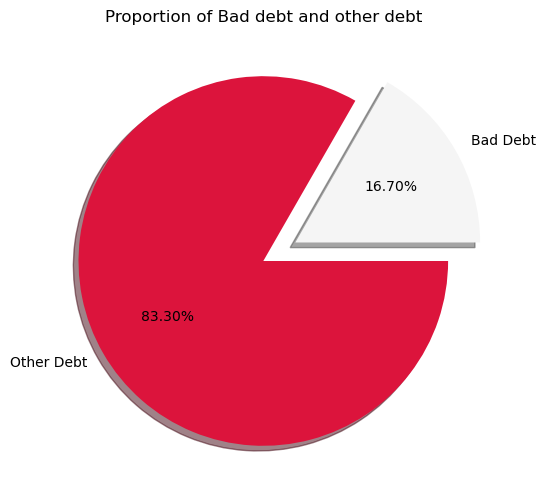

In [21]:
size=[val_bad_debt,val_other_debt]
lable=['Bad Debt','Other Debt']
explode=[0.2,0]
color=['whitesmoke','crimson']

plt.figure(figsize=(8,6))
plt.pie(size,labels=lable,explode=explode,colors=color,autopct='%1.2f%%',shadow=True, startangle=0,radius=1)
plt.title("Proportion of Bad debt and other debt")
plt.savefig("Pie_cart_debt_prportion.png")

#### From above pie chart we can see that out of total debt related to houses, 16.70% is bad debt

## ---------------------------------------------------------------------

#### Here we will analyze how is the distribution for 2nd mortgage, home equity, good debt, and bad debt for top 10 states 

## ---------------------------------------------------------------------

In [22]:
_2nd_morg_state=list(real_estate_data.groupby(by='state')['second_mortgage'].agg('mean').sort_values(ascending=False)[:10].index)
home_equity_state=list(real_estate_data.groupby(by='state')['home_equity'].agg('mean').sort_values(ascending=False)[:10].index)
good_debt_state=list(real_estate_data.groupby(by='state')['Good_debt'].agg('mean').sort_values(ascending=False)[:10].index)
Bad_Debt_state=list(real_estate_data.groupby(by='state')['Bad_Debt'].agg('mean').sort_values(ascending=False)[:10].index)

In [23]:
lst1=[]
lst2=[]
for ind,val in enumerate(real_estate_data['state']):
    if val in _2nd_morg_state:
        lst1.append(real_estate_data.loc[real_estate_data.index==real_estate_data.index[ind],'second_mortgage'].values[0])
        lst2.append(val)
mor_df=pd.DataFrame({'lst1':lst1,'lst2':lst2})
        

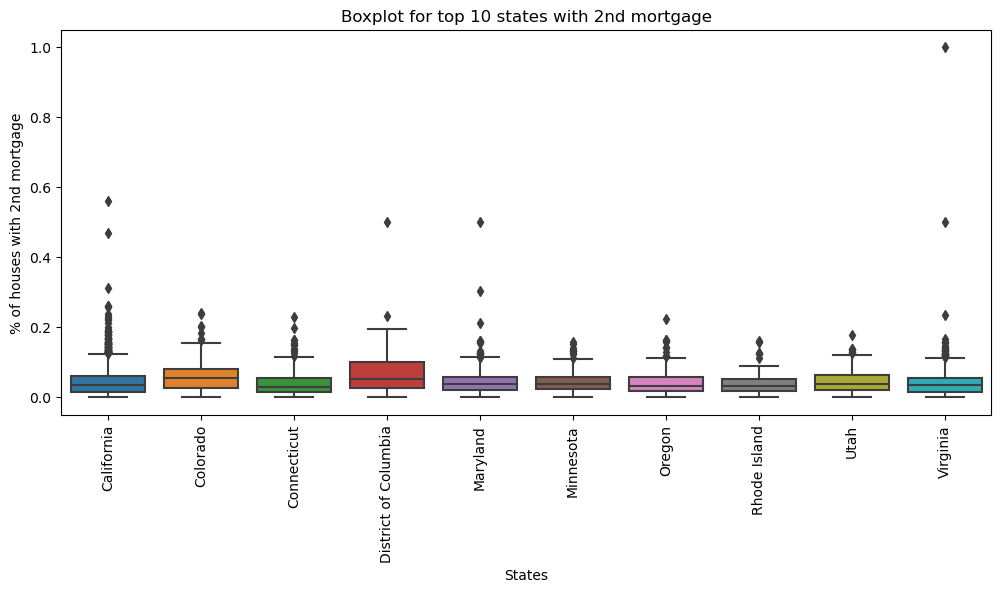

In [24]:
plt.figure(figsize=(12,5))
sbn.boxplot(y=mor_df['lst1'],x=mor_df['lst2'])
plt.xlabel("States")
plt.ylabel("% of houses with 2nd mortgage")
plt.xticks(rotation='vertical')
plt.title("Boxplot for top 10 states with 2nd mortgage")
plt.savefig("box_2nd_mortgage.png")


In [25]:
lst2=[]
lst3=[]
for ind,val in enumerate(real_estate_data['state']):
    if val in home_equity_state:
        lst2.append(real_estate_data.loc[real_estate_data.index==real_estate_data.index[ind],'home_equity'].values[0])
        lst3.append(val)
equity_df=pd.DataFrame({'lst2':lst2,'lst3':lst3})

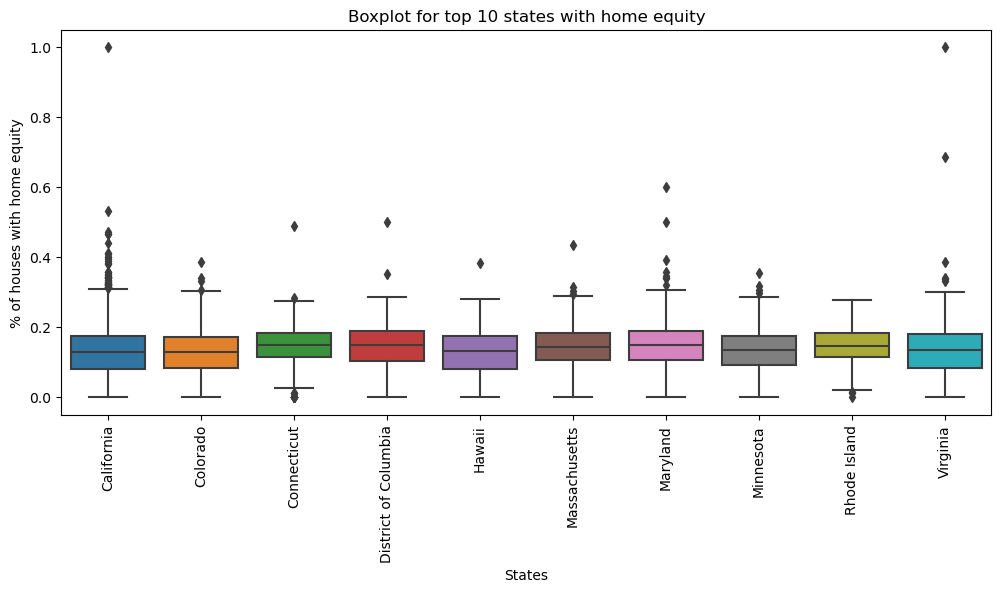

In [26]:
plt.figure(figsize=(12,5))
sbn.boxplot(y=equity_df['lst2'],x=equity_df['lst3'])
plt.xlabel("States")
plt.ylabel("% of houses with home equity")
plt.xticks(rotation='vertical')
plt.title("Boxplot for top 10 states with home equity")
plt.savefig("box_home_equity.png")


In [27]:
lst5=[]
lst6=[]
for ind,val in enumerate(real_estate_data['state']):
    if val in good_debt_state:
        lst5.append(real_estate_data.loc[real_estate_data.index==real_estate_data.index[ind],'second_mortgage'].values[0])
        lst6.append(val)
good_df=pd.DataFrame({'lst5':lst5,'lst6':lst6})
        

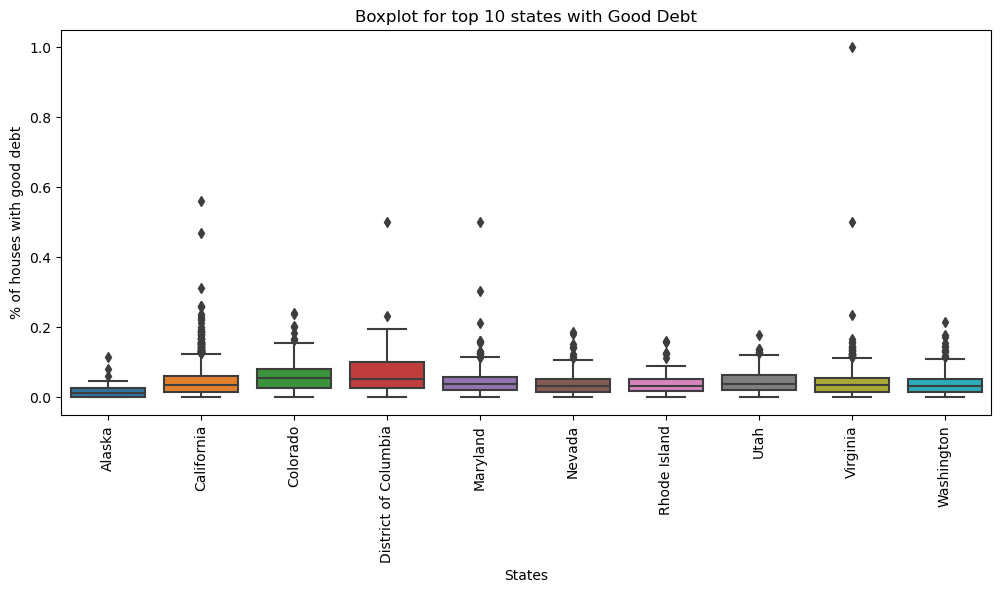

In [28]:
plt.figure(figsize=(12,5))
sbn.boxplot(y=good_df['lst5'],x=good_df['lst6'])
plt.xlabel("States")
plt.ylabel("% of houses with good debt")
plt.xticks(rotation=90)
plt.title("Boxplot for top 10 states with Good Debt")
plt.savefig("box_good_debt.png")


In [29]:
lst7=[]
lst8=[]
for ind,val in enumerate(real_estate_data['state']):
    if val in Bad_Debt_state:
        lst7.append(real_estate_data.loc[real_estate_data.index==real_estate_data.index[ind],'second_mortgage'].values[0])
        lst8.append(val)
bad_df=pd.DataFrame({'lst7':lst7,'lst8':lst8})
        

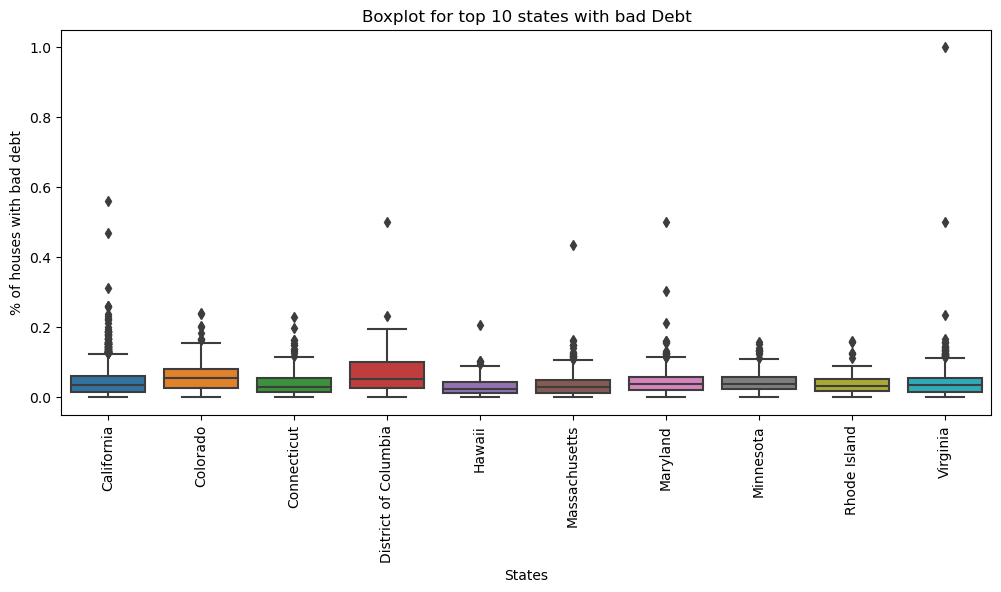

In [30]:
plt.figure(figsize=(12,5))
sbn.boxplot(y=bad_df['lst7'],x=bad_df['lst8'])
plt.xlabel("States")
plt.ylabel("% of houses with bad debt")
plt.xticks(rotation='vertical')
plt.title("Boxplot for top 10 states with bad Debt")
plt.savefig("box_bad_debt.png")


## ---------------------------------------------------------------------

#### Here we will analyze distribution for family income, house hold income, and remaining income

## ---------------------------------------------------------------------

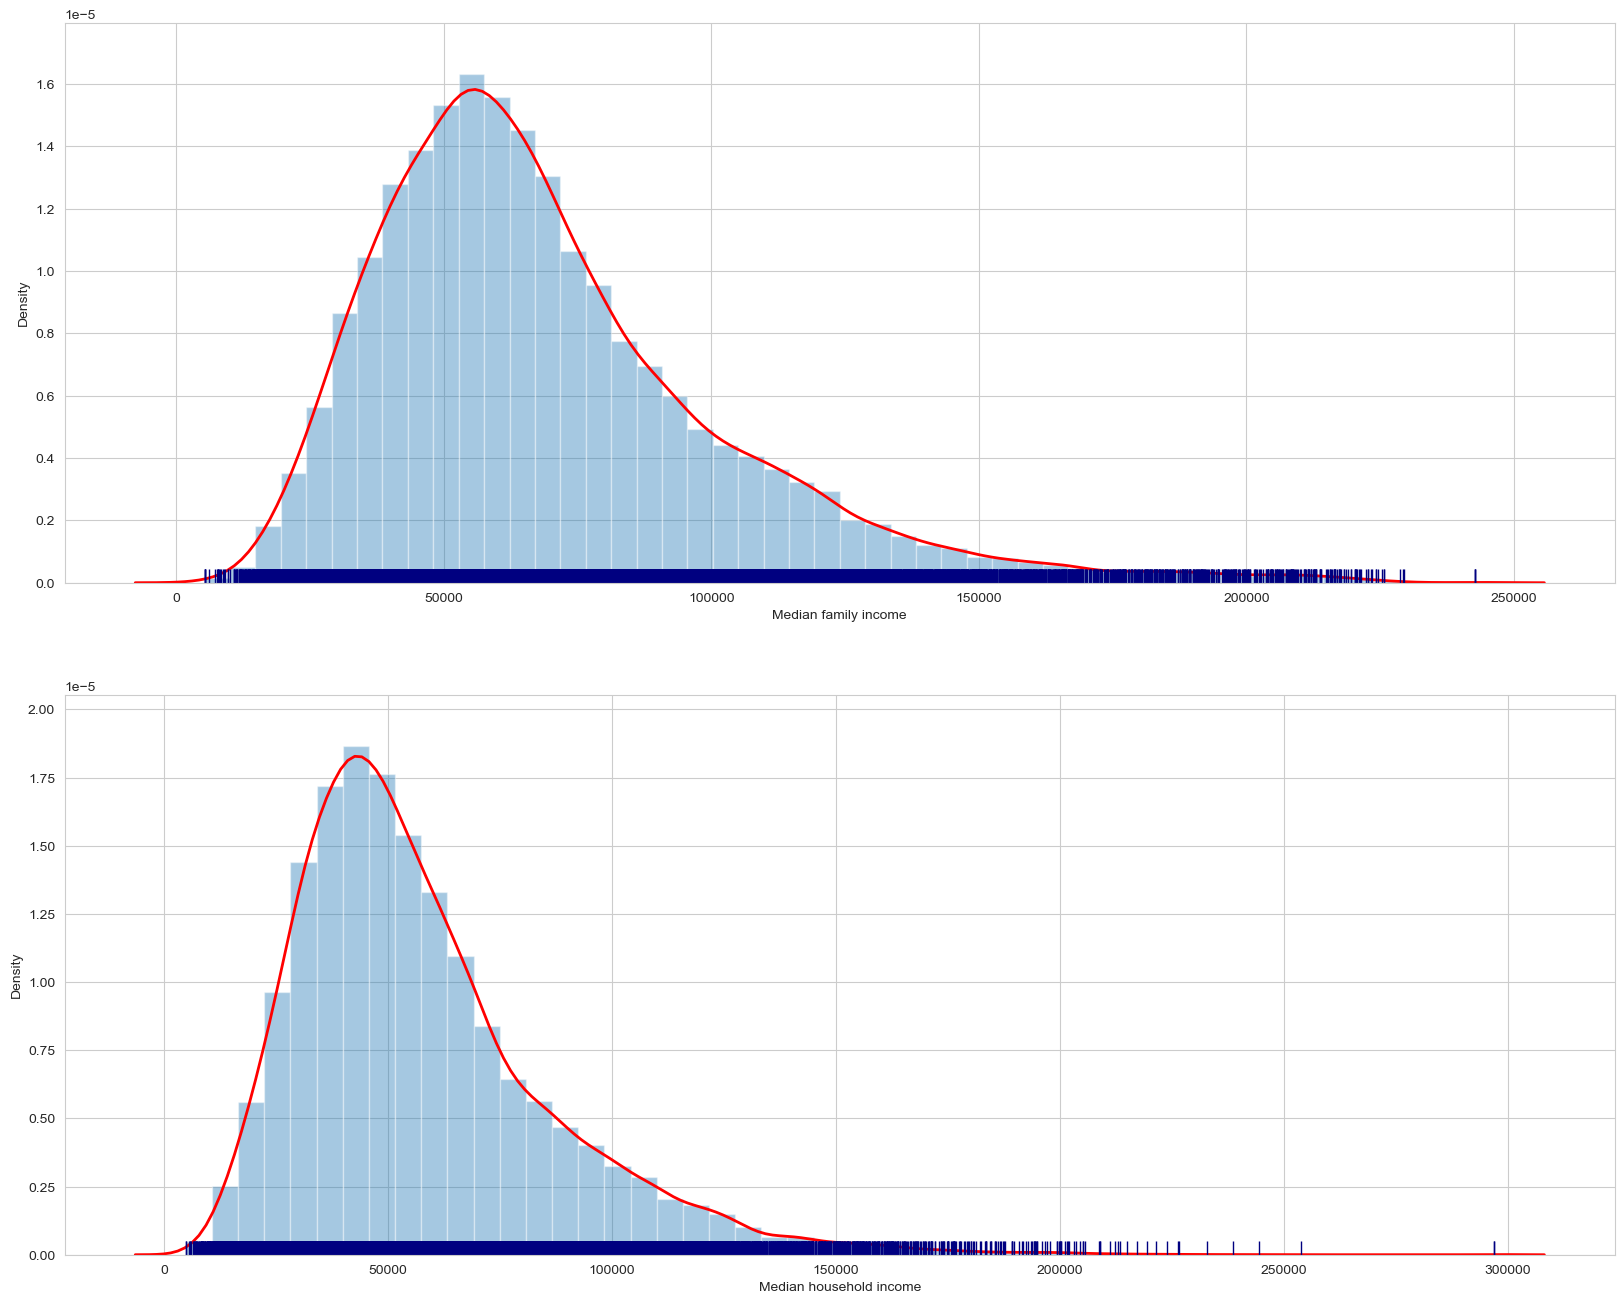

In [31]:
plt.figure(figsize=(20,16))
sbn.set_style('whitegrid')
plt.subplot(2,1,1)
sbn.distplot(real_estate_data['family_median'],kde=True,kde_kws={'lw':2,'color':'red'},rug=True,rug_kws={'color':'navy'})
plt.xlabel("Median family income")

plt.subplot(2,1,2)
sbn.distplot(real_estate_data['hi_median'],kde=True,kde_kws={'lw':2,'color':'red'},rug=True,rug_kws={'color':'navy'})
plt.xlabel("Median household income")

plt.savefig('distplots.png')

## ---------------------------------------------------------------------

#### Here we will do population analysis

## ---------------------------------------------------------------------

In [32]:
real_estate_data['pop_density']=real_estate_data['pop']/real_estate_data['ALand']

<AxesSubplot:xlabel='lat', ylabel='lng'>

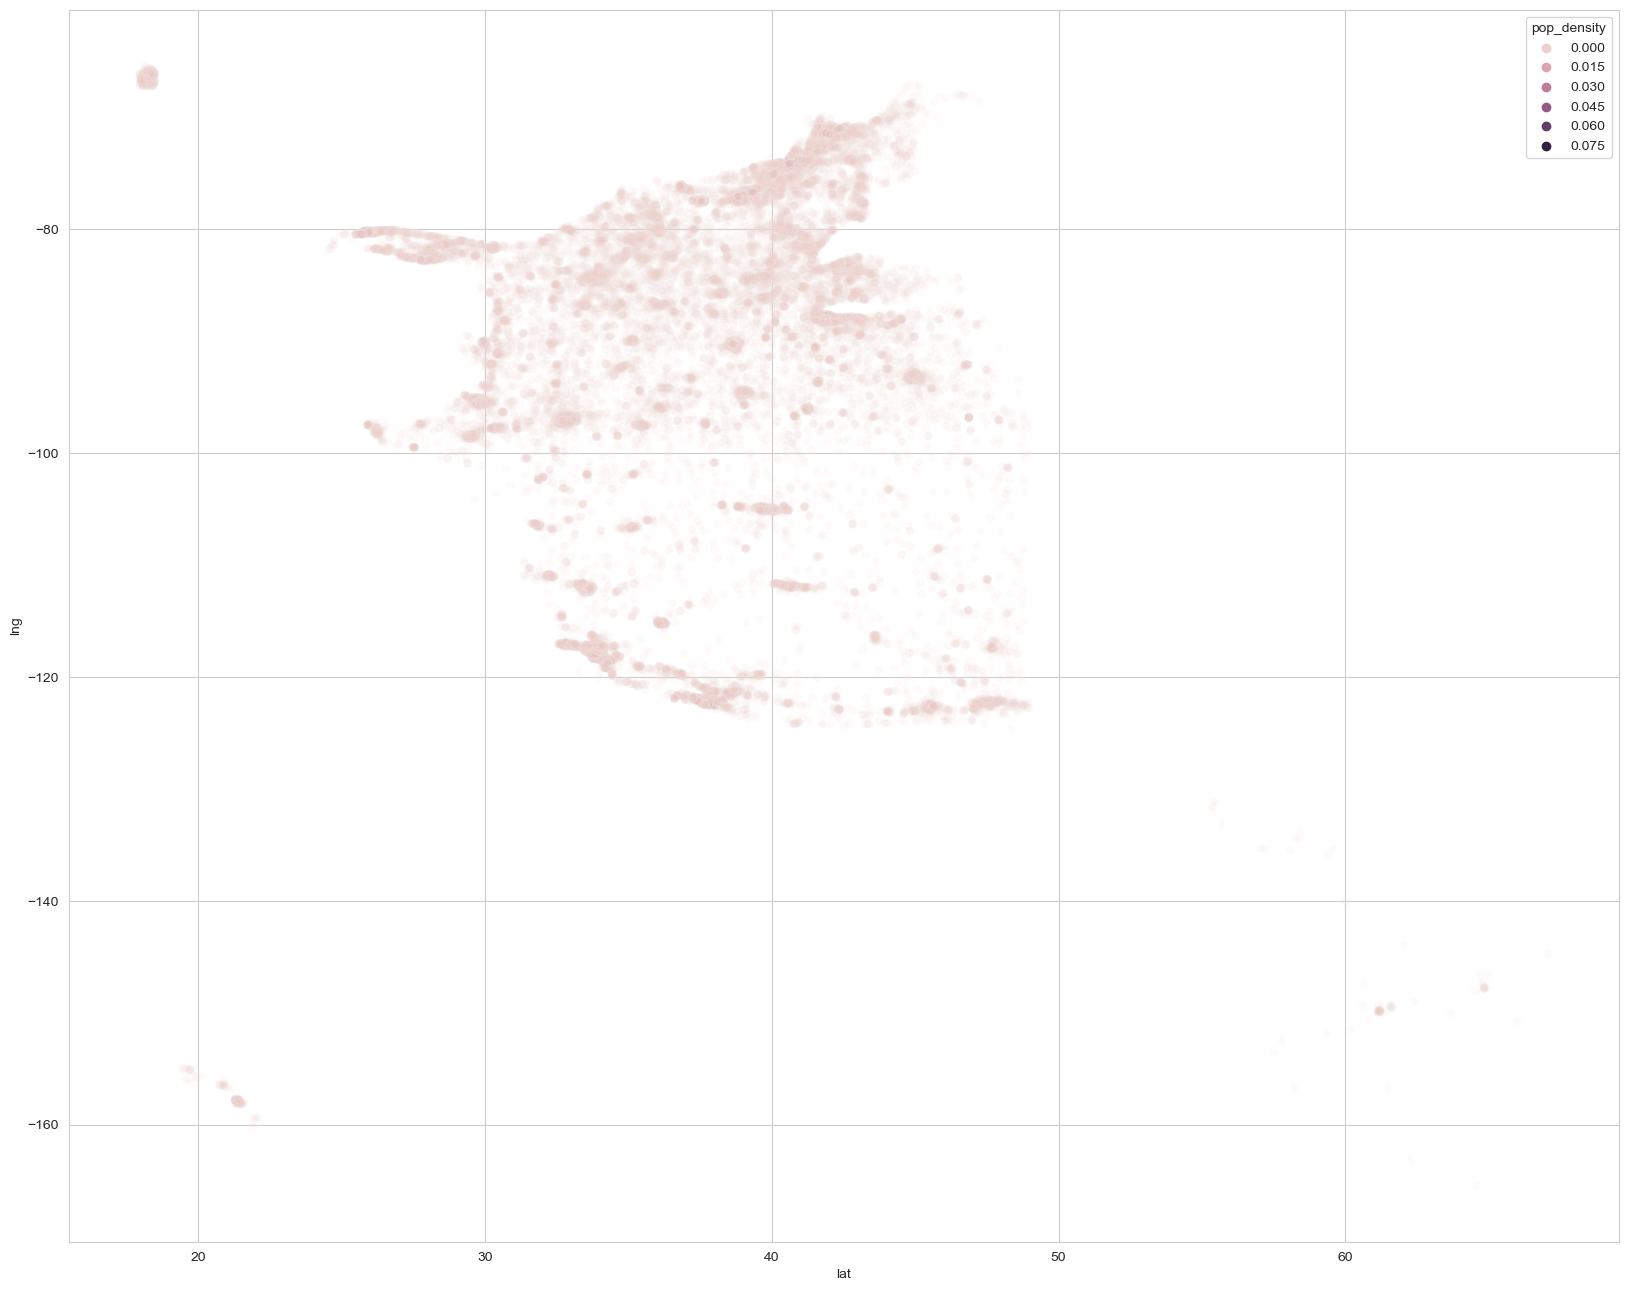

In [33]:
# We will plot a scatter plot and will analyze the population density
plt.figure(figsize=(20,16))
sbn.scatterplot(x=real_estate_data['lat'],y=real_estate_data['lng'],hue=real_estate_data['pop_density'],alpha=0.1,color='red')


In [34]:
# We will find out top 5 states with highest population and wilol then see what is the ration of male to female population in those states

pv_table=pd.pivot_table(real_estate_data,index=['state'],
                        values=['male_pop','female_pop','pop'],aggfunc='sum').sort_values(by='pop',ascending=False)[:5]

In [35]:
pv_table

,female_pop,male_pop,pop
state,,,
California,7043954,6979423,14023377
Texas,4933871,4845154,9779025
Florida,3754947,3599456,7354403
New York,3674293,3451016,7125309
Pennsylvania,2421103,2308892,4729995


In [36]:
female_pop=pv_table.loc[pv_table.index=='California','female_pop'].values[0]
male_pop=pv_table.loc[pv_table.index=='California','male_pop'].values[0]

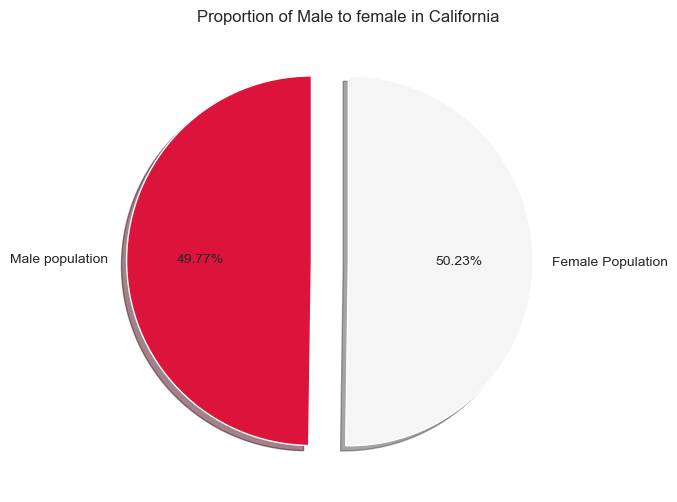

In [37]:
size=[male_pop,female_pop]
lable=['Male population','Female Population']
explode=[0.2,0]
color=['crimson','whitesmoke']

plt.figure(figsize=(8,6))
plt.pie(size,labels=lable,explode=explode,colors=color,autopct='%1.2f%%',shadow=True, startangle=90,radius=1)
plt.title("Proportion of Male to female in California")
plt.savefig("Pie_cart_gender_cal.png")

In [38]:
female_pop=pv_table.loc[pv_table.index=='Texas','female_pop'].values[0]
male_pop=pv_table.loc[pv_table.index=='Texas','male_pop'].values[0]

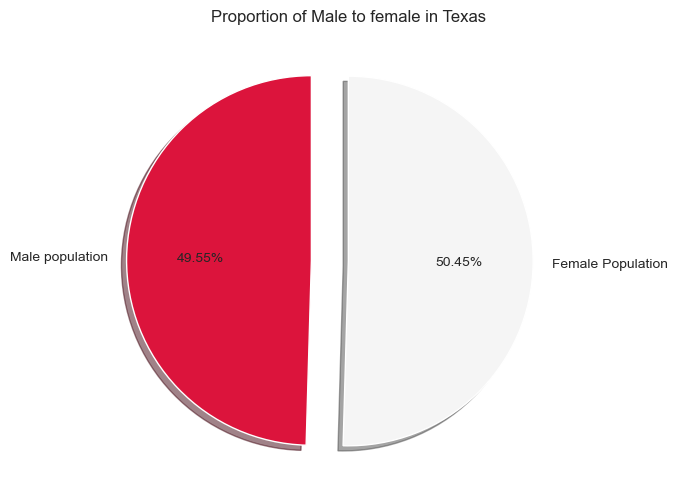

In [39]:
size=[male_pop,female_pop]
lable=['Male population','Female Population']
explode=[0.2,0]
color=['crimson','whitesmoke']

plt.figure(figsize=(8,6))
plt.pie(size,labels=lable,explode=explode,colors=color,autopct='%1.2f%%',shadow=True, startangle=90,radius=1)
plt.title("Proportion of Male to female in Texas")
plt.savefig("Pie_cart_gender_Texas.png")

In [40]:
female_pop=pv_table.loc[pv_table.index=='Florida','female_pop'].values[0]
male_pop=pv_table.loc[pv_table.index=='Florida','male_pop'].values[0]

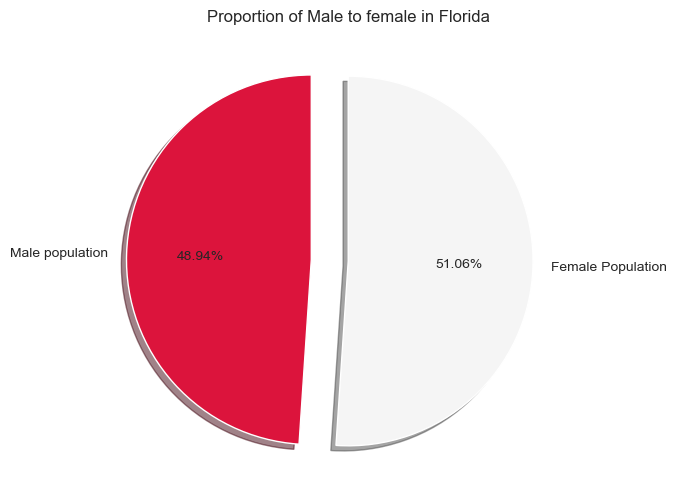

In [41]:
size=[male_pop,female_pop]
lable=['Male population','Female Population']
explode=[0.2,0]
color=['crimson','whitesmoke']

plt.figure(figsize=(8,6))
plt.pie(size,labels=lable,explode=explode,colors=color,autopct='%1.2f%%',shadow=True, startangle=90,radius=1)
plt.title("Proportion of Male to female in Florida")
plt.savefig("Pie_cart_gender_florida.png")

In [42]:
female_pop=pv_table.loc[pv_table.index=='New York','female_pop'].values[0]
male_pop=pv_table.loc[pv_table.index=='New York','male_pop'].values[0]

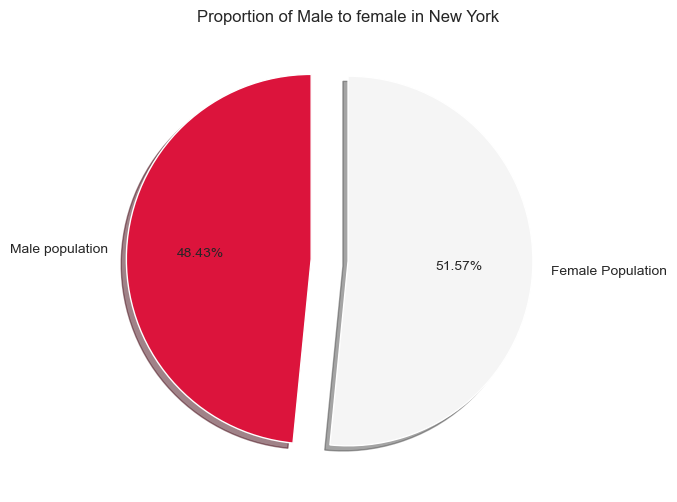

In [43]:
size=[male_pop,female_pop]
lable=['Male population','Female Population']
explode=[0.2,0]
color=['crimson','whitesmoke']

plt.figure(figsize=(8,6))
plt.pie(size,labels=lable,explode=explode,colors=color,autopct='%1.2f%%',shadow=True, startangle=90,radius=1)
plt.title("Proportion of Male to female in New York")
plt.savefig("Pie_cart_gender_New York.png")

In [44]:
female_pop=pv_table.loc[pv_table.index=='Pennsylvania','female_pop'].values[0]
male_pop=pv_table.loc[pv_table.index=='Pennsylvania','male_pop'].values[0]

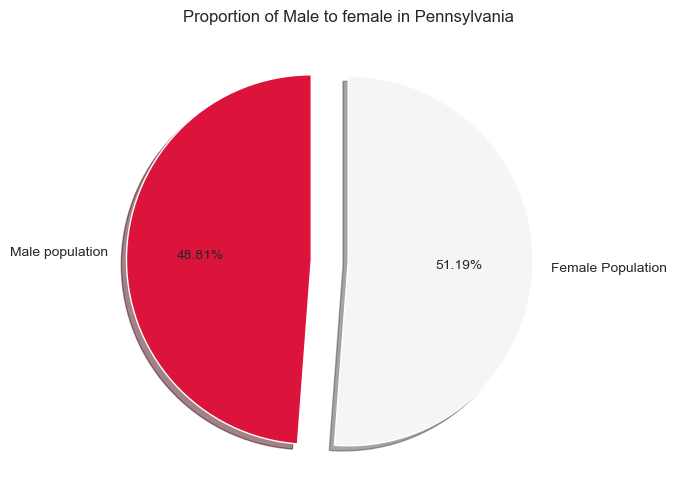

In [45]:
size=[male_pop,female_pop]
lable=['Male population','Female Population']
explode=[0.2,0]
color=['crimson','whitesmoke']

plt.figure(figsize=(8,6))
plt.pie(size,labels=lable,explode=explode,colors=color,autopct='%1.2f%%',shadow=True, startangle=90,radius=1)
plt.title("Proportion of Male to female in Pennsylvania")
plt.savefig("Pie_cart_gender_Pennsylvania.png")

## ---------------------------------------------------------------------

#### Here we will do rent analysis

## ---------------------------------------------------------------------

In [46]:
real_estate_data['pct_rent']=round((real_estate_data['rent_median']/real_estate_data['hi_median'])*100,2)

In [47]:

pv_table=pd.pivot_table(real_estate_data,index=['state'],
                        values=['pct_rent'],aggfunc='mean').sort_values(by='pct_rent',ascending=False)[:5]

In [48]:
pv_table

,pct_rent
state,
Puerto Rico,2.581150
Florida,2.356619
California,2.304513
Hawaii,2.301280
New York,2.129689


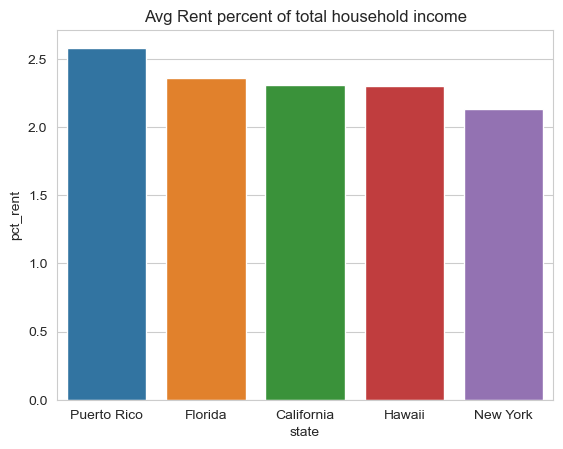

In [49]:
sbn.barplot(x=pv_table.index,y=pv_table.pct_rent)
plt.title("Avg Rent percent of total household income")
plt.savefig("rent analysis.png")

# ---------------------------------------------------------------------

#### Here we will perform correlation analysis

## ---------------------------------------------------------------------

In [50]:
num_data=real_estate_data.select_dtypes(include=[np.number])

<AxesSubplot:>

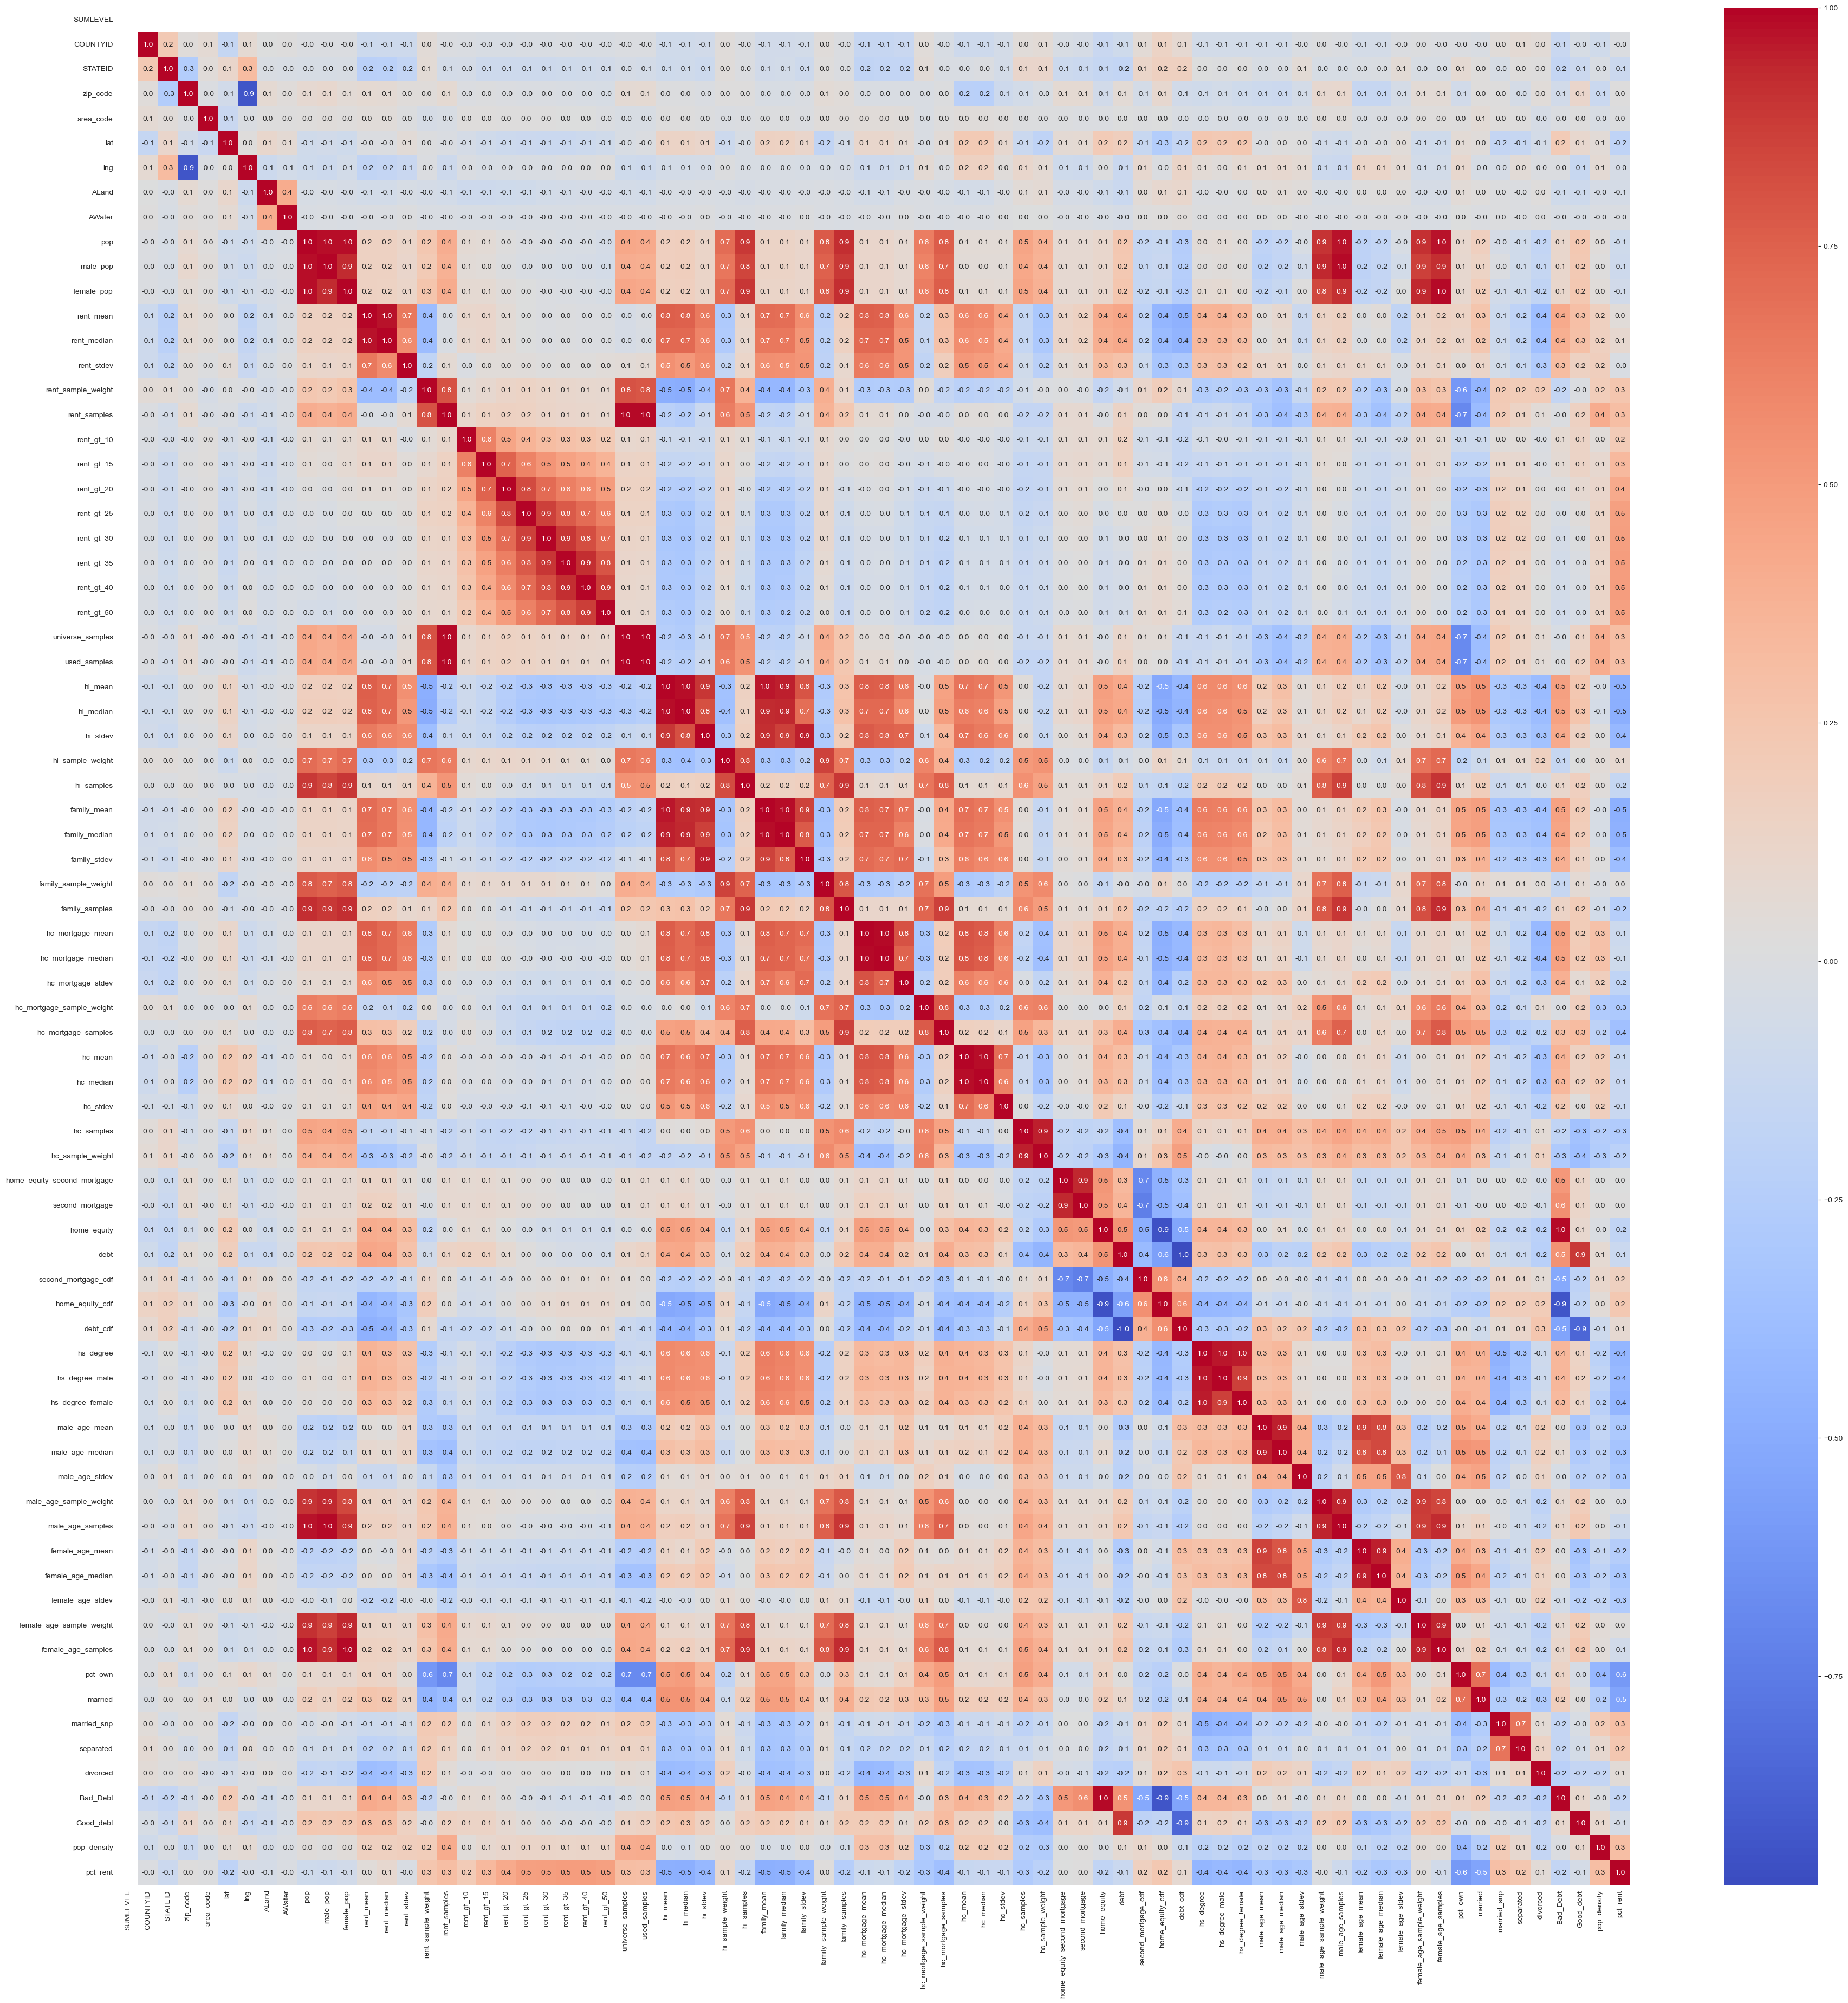

In [51]:
plt.figure(figsize=(45,45))
sbn.heatmap(num_data.corr(),annot=True,fmt='1.1f',cmap="coolwarm",color='blue')

### From the above heatmap of correlation matrix, we can see that there exists some multicolinearity within the independent varaibles as well.

# ---------------------------------------------------------------------

#### importing and preprocessing on test data to make it ML-ready

# ---------------------------------------------------------------------

In [52]:
# We will import the test data

real_estate_test=pd.read_csv("test.csv")

In [53]:
real_estate_test.shape

(11709, 80)

In [54]:
# test data preparation
# Making UID as index
real_estate_test.index=real_estate_test['UID']
real_estate_test.drop('UID',axis=1,inplace=True)
real_estate_test=real_estate_test.sort_values(by='UID', ascending=True)

In [55]:
# missing value treatment
round((real_estate_test.isnull().sum()/real_estate_test.shape[0])*100,2).sort_values(ascending=False)

BLOCKID       100.00
hc_samples      2.48
hc_mean         2.48
hc_median       2.48
hc_stdev        2.48
               ...  
type            0.00
place           0.00
city            0.00
state           0.00
state_ab        0.00
Length: 79, dtype: float64

In [56]:
# We will create same columns which we created for training Dataset
real_estate_test.drop('BLOCKID',axis=1,inplace=True)

In [57]:
# We will create a list of columns with missing vales, will analize and then we will see how to fill missing values
missing_value_lst_tst=[i for i in real_estate_test if real_estate_test[i].isnull().sum()>0]
print(missing_value_lst_tst)

['rent_mean', 'rent_median', 'rent_stdev', 'rent_sample_weight', 'rent_samples', 'rent_gt_10', 'rent_gt_15', 'rent_gt_20', 'rent_gt_25', 'rent_gt_30', 'rent_gt_35', 'rent_gt_40', 'rent_gt_50', 'hi_mean', 'hi_median', 'hi_stdev', 'hi_sample_weight', 'hi_samples', 'family_mean', 'family_median', 'family_stdev', 'family_sample_weight', 'family_samples', 'hc_mortgage_mean', 'hc_mortgage_median', 'hc_mortgage_stdev', 'hc_mortgage_sample_weight', 'hc_mortgage_samples', 'hc_mean', 'hc_median', 'hc_stdev', 'hc_samples', 'hc_sample_weight', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'debt', 'second_mortgage_cdf', 'home_equity_cdf', 'debt_cdf', 'hs_degree', 'hs_degree_male', 'hs_degree_female', 'male_age_mean', 'male_age_median', 'male_age_stdev', 'male_age_sample_weight', 'male_age_samples', 'female_age_mean', 'female_age_median', 'female_age_stdev', 'female_age_sample_weight', 'female_age_samples', 'pct_own', 'married', 'married_snp', 'separated', 'divorced']


In [58]:
real_estate_test[missing_value_lst_tst].info()

<class 'pandas.core.frame.DataFrame'>
Index: 11709 entries, 220336 to 294333
Data columns (total 58 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   rent_mean                    11561 non-null  float64
 1   rent_median                  11561 non-null  float64
 2   rent_stdev                   11561 non-null  float64
 3   rent_sample_weight           11561 non-null  float64
 4   rent_samples                 11561 non-null  float64
 5   rent_gt_10                   11560 non-null  float64
 6   rent_gt_15                   11560 non-null  float64
 7   rent_gt_20                   11560 non-null  float64
 8   rent_gt_25                   11560 non-null  float64
 9   rent_gt_30                   11560 non-null  float64
 10  rent_gt_35                   11560 non-null  float64
 11  rent_gt_40                   11560 non-null  float64
 12  rent_gt_50                   11560 non-null  float64
 13  hi_mean        

In [59]:
data=real_estate_test[missing_value_lst_tst]
for i in data:
    if i.endswith('median') or i.startswith('median'):
        for ind, val in enumerate(data[i]):
            if pd.isna(val):
                ct=real_estate_test.loc[real_estate_test.index==real_estate_test.index[ind],'state'].values[0] # get the state
                val2=real_estate_test[real_estate_test['state']==ct][i].median() # get the median value of the feature for corersponding state
                real_estate_test.loc[real_estate_test.index==real_estate_test.index[ind],i]=val2 # fill the missing value with the median value                     
                                                      
    else:
        for ind, val in enumerate(data[i]):
            if pd.isna(val):
                ct=real_estate_test.loc[real_estate_test.index==real_estate_test.index[ind],'state'].values[0]
                val2=real_estate_test[real_estate_test['state']==ct][i].mean()
                real_estate_test.loc[real_estate_test.index==real_estate_test.index[ind],i]=val2   
                                      

In [60]:
real_estate_test.isnull().sum().sort_values(ascending=False)[:10]

SUMLEVEL                       0
hc_median                      0
debt                           0
home_equity                    0
second_mortgage                0
home_equity_second_mortgage    0
hc_sample_weight               0
hc_samples                     0
hc_stdev                       0
hc_mean                        0
dtype: int64

In [61]:
# We will prepre the columns which we prepared for train data
real_estate_test['Bad_Debt']=real_estate_test['second_mortgage']+real_estate_test['home_equity'] - real_estate_test['home_equity_second_mortgage']
real_estate_test['Good_debt']=real_estate_test['debt']-real_estate_test['Bad_Debt']
real_estate_test['pop_density']=real_estate_test['pop']/real_estate_test['ALand']
real_estate_test['pct_rent']=round((real_estate_test['rent_median']/real_estate_test['hi_median'])*100,2)

# ---------------------------------------------------------------------

#### ML model Building part

## ---------------------------------------------------------------------

#### We will build the model at the national level first and we will build it at state level,We will drop some columns to do that


In [62]:
nat_train=real_estate_data.drop(['COUNTYID','STATEID','state_ab','city','place','type',
                       'primary','zip_code','area_code','lat','lng'],axis=1)

In [63]:
nat_test=real_estate_test.drop(['COUNTYID','STATEID','state_ab','city','place','type',
                       'primary','zip_code','area_code','lat','lng'],axis=1)

In [64]:
print(nat_train.shape)
print(nat_test.shape)

(27161, 71)
(11709, 71)


In [65]:
#converting state into numerical
nat_train_dummy=pd.get_dummies(nat_train['state'],prefix='st',dtype=int,drop_first=True)
nat_test_dummy=pd.get_dummies(nat_test['state'],prefix='st',dtype=int,drop_first=True)

In [66]:
# concatanating the data
nat_train_new=pd.concat([nat_train,nat_train_dummy],axis=1)
nat_test_new=pd.concat([nat_test,nat_test_dummy],axis=1)

In [67]:
# dropping the original state column
nat_train_new.drop('state',axis=1,inplace=True)
nat_test_new.drop('state',axis=1,inplace=True)

In [68]:
# We will do outlier treatment
# Outlier Treatment

def out_treatment(Data):
   
    if type(Data)!=pd.Series:
        data=Data.select_dtypes(include=[np.number])
        
        for i in data:
            q1=data[i].quantile(0.25)
            q3=data[i].quantile(0.75)
            iqr=q3-q1
            maxx=q3+1.5*iqr
            minn=q1-1.5*iqr
            for k in data[i]:
                if k>maxx:
                    data[i].replace(k,maxx,inplace=True)
                elif k<minn:
                    data[i].replace(k,minn,inplace=True)
                    
        return data

    else :
        q1=data.quantile(0.25)
        q3=data.quantile(0.75)
        iqr=q3-q1
        maxx=q3+1.5*iqr
        minn=q1-1.5*iqr
        for i in data:
            if i>maxx:
                    data.replace(i,maxx)
            elif i<minn:
                data.replace(i,minn)
    return data
            

In [69]:
nat_train_new_cleaned=out_treatment(nat_train_new)
nat_test_new_cleaned=out_treatment(nat_test_new)

In [70]:
# We will convert the data into X and y

X_train=nat_train_new_cleaned.drop('hc_mortgage_mean',axis=1)
y_train=nat_train_new_cleaned['hc_mortgage_mean'].values
X_test=nat_test_new_cleaned.drop('hc_mortgage_mean',axis=1)
y_test=nat_test_new_cleaned['hc_mortgage_mean'].values

In [71]:
# We will scale the data
std_sc=StandardScaler()
x_train_scaled=std_sc.fit_transform(X_train)
x_test_scaled=std_sc.transform(X_test)

In [72]:
# We will Use principal component analysis to get the features decomposed
elnet=ElasticNet()
lst_ncomponent=[]
lst_rmse=[]

for i in range(1,10,1):
    pca=PCA(n_components=i)
    x_train_pc=pca.fit_transform(x_train_scaled)
    x_test_pc=pca.transform(x_test_scaled)
    elnet.fit(x_train_pc,y_train)
    y_pred_train=elnet.predict(x_test_pc)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred_train))
    lst_rmse.append(rmse)
    lst_ncomponent.append(i)


In [73]:
for i in range(10,20,1):
    pca=PCA(n_components=i)
    x_train_pc=pca.fit_transform(x_train_scaled)
    x_test_pc=pca.transform(x_test_scaled)
    elnet.fit(x_train_pc,y_train)
    y_pred_train=elnet.predict(x_test_pc)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred_train))
    lst_rmse.append(rmse)
    lst_ncomponent.append(i)

In [74]:
for i in range(20,40,1):
    pca=PCA(n_components=i)
    x_train_pc=pca.fit_transform(x_train_scaled)
    x_test_pc=pca.transform(x_test_scaled)
    elnet.fit(x_train_pc,y_train)
    y_pred_train=elnet.predict(x_test_pc)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred_train))
    lst_rmse.append(rmse)
    lst_ncomponent.append(i)

In [75]:
for i in range(40,60,1):
    pca=PCA(n_components=i)
    x_train_pc=pca.fit_transform(x_train_scaled)
    x_test_pc=pca.transform(x_test_scaled)
    elnet.fit(x_train_pc,y_train)
    y_pred_train=elnet.predict(x_test_pc)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred_train))
    lst_rmse.append(rmse)
    lst_ncomponent.append(i)

In [76]:
for i in range(60,80,1):
    pca=PCA(n_components=i)
    x_train_pc=pca.fit_transform(x_train_scaled)
    x_test_pc=pca.transform(x_test_scaled)
    elnet.fit(x_train_pc,y_train)
    y_pred_train=elnet.predict(x_test_pc)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred_train))
    lst_rmse.append(rmse)
    lst_ncomponent.append(i)

In [77]:
for i in range(80,100,1):
    pca=PCA(n_components=i)
    x_train_pc=pca.fit_transform(x_train_scaled)
    x_test_pc=pca.transform(x_test_scaled)
    elnet.fit(x_train_pc,y_train)
    y_pred_train=elnet.predict(x_test_pc)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred_train))
    lst_rmse.append(rmse)
    lst_ncomponent.append(i)

In [78]:
for i in range(100,121,1):
    pca=PCA(n_components=i)
    x_train_pc=pca.fit_transform(x_train_scaled)
    x_test_pc=pca.transform(x_test_scaled)
    elnet.fit(x_train_pc,y_train)
    y_pred_train=elnet.predict(x_test_pc)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred_train))
    lst_rmse.append(rmse)
    lst_ncomponent.append(i)

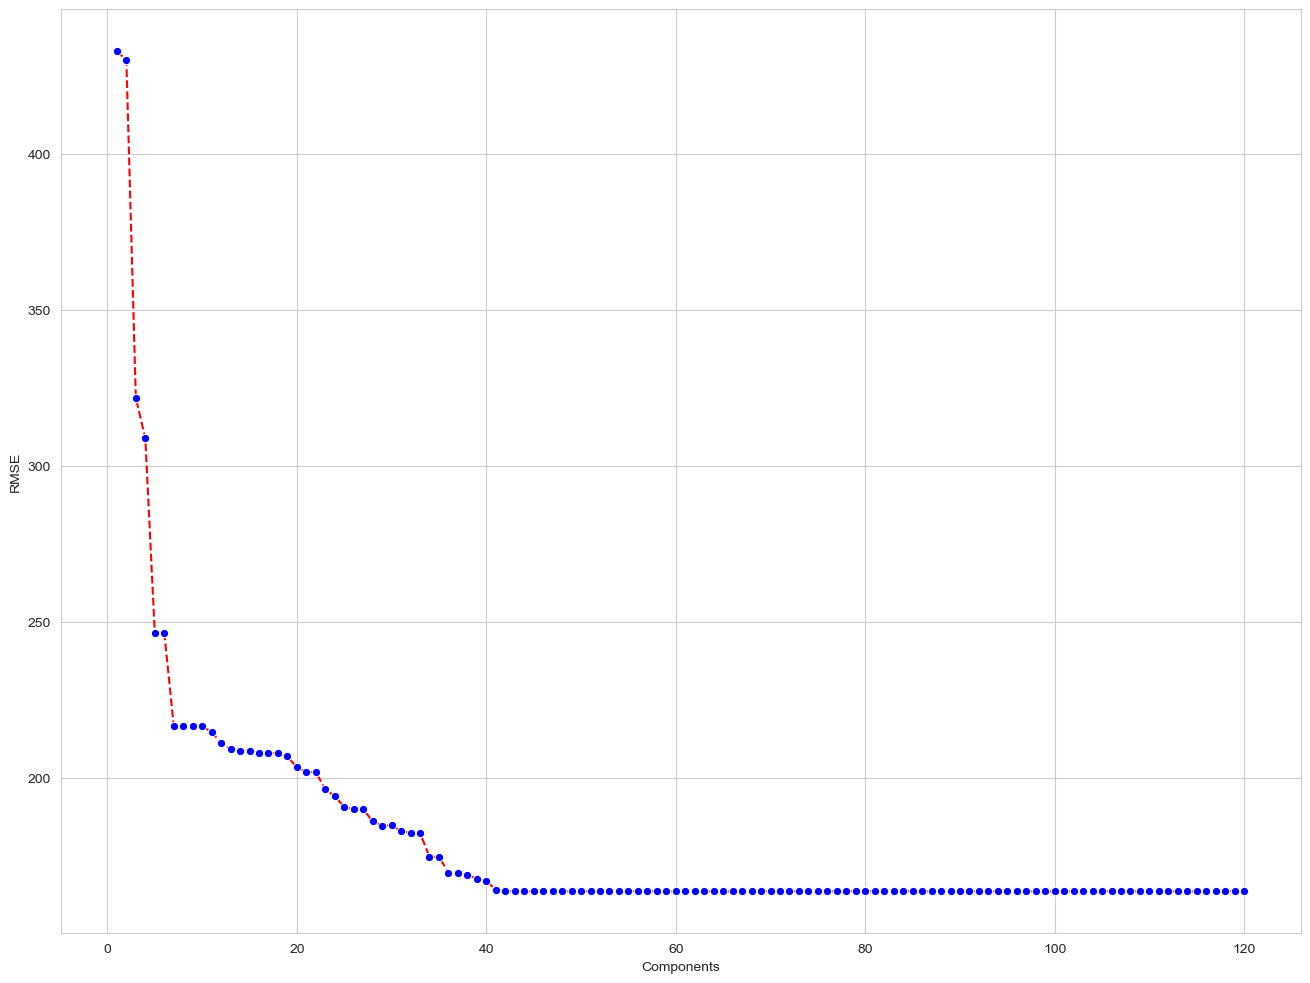

In [79]:
plt.figure(figsize=(16,12))
sbn.lineplot(x=lst_ncomponent,y=lst_rmse,marker='o',markerfacecolor='blue',color='red', linestyle='dashed')
plt.xlabel("Components")
plt.ylabel("RMSE")
plt.savefig("PCA graph_Nat.png")

##### From above graph it is clear that from n component 41 onwards RMSE remains the constant low.So we will select 41 as our n components

In [80]:
pca=PCA(n_components=41)
x_train_pc=pca.fit_transform(x_train_scaled)
x_test_pc=pca.transform(x_test_scaled)

##### now, with the help of gridsearchcv, we will find best RMSE for elecsticnet amd we will also use simple linear regression to see if it performs better

In [81]:
# defining hyper parameters to tune in
hyper_param={'alpha':[0,1,0.1,0.01,0.001,0.02,0.02,0.05,0.5,10,20,30,40,50,60],
            'l1_ratio':[0,0.01,0.02,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

In [82]:
elnet=ElasticNet()

# Using Gridsearch to find best parameters
gscv=GridSearchCV(estimator=elnet,param_grid=hyper_param,scoring='neg_mean_squared_error',cv=5,n_jobs=4)
gscv.fit(x_train_pc,y_train)

GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=4,
             param_grid={'alpha': [0, 1, 0.1, 0.01, 0.001, 0.02, 0.02, 0.05,
                                   0.5, 10, 20, 30, 40, 50, 60],
                         'l1_ratio': [0, 0.01, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5,
                                      0.6, 0.7, 0.8, 0.9, 1]},
             scoring='neg_mean_squared_error')

In [83]:
print(gscv.best_params_)
print(gscv.best_score_)

{'alpha': 0, 'l1_ratio': 0}
-4825.64666479622


In [84]:

# we will create an instance with best parameter with the best parameters
elnet=ElasticNet(**gscv.best_params_)
# Will fit the data
elnet.fit(x_train_pc,y_train)
# we will get our predictions
pred_train=elnet.predict(x_test_pc)
# we will calculate rmse
rmse=np.sqrt(mean_squared_error(pred_train,y_test))



In [85]:
print(rmse)

72.48085910249512


In [86]:
# will will check our r2 score
r2_score=elnet.score(x_train_pc,y_train)
print(r2_score)

0.9869747291009837


In [87]:
#lets see if we get simillar r2 adjusted

x1=sm.add_constant(x_train_pc)
sts=sm.OLS(y_train,x1)
sts1=sts.fit()
print(sts1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 5.012e+04
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        23:47:04   Log-Likelihood:            -1.5348e+05
No. Observations:               27161   AIC:                         3.070e+05
Df Residuals:                   27119   BIC:                         3.074e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1625.0321      0.418   3887.199      0.0

#### We will build the model at the state level now

In [88]:
st_train=real_estate_data.drop(['COUNTYID','STATEID','state_ab','state','place','type',
                       'primary','zip_code','area_code','lat','lng'],axis=1)
st_test=real_estate_test.drop(['COUNTYID','STATEID','state_ab','state','place','type',
                       'primary','zip_code','area_code','lat','lng'],axis=1)

In [89]:
print(st_train.shape)
print(st_test.shape)

(27161, 71)
(11709, 71)


In [90]:
len(st_train['city'].value_counts())

6916

In [91]:
len(st_test['city'].value_counts())

4369

#### From the shapes we can see that we can not use dummy encodin as it will create different number of features

In [92]:
#converting city into numerical
lbl_enco=LabelEncoder()
st_train['city']=lbl_enco.fit_transform(st_train['city'])
st_test['city']=lbl_enco.fit_transform(st_test['city'])

In [93]:
# outlier treatment
st_train_new_cleaned=out_treatment(st_train)
st_test_new_cleaned=out_treatment(st_test)

In [94]:
# We will convert the data into X and y

X_train_st=st_train_new_cleaned.drop('hc_mortgage_mean',axis=1)
y_train_st=st_train_new_cleaned['hc_mortgage_mean']
X_test_st=st_test_new_cleaned.drop('hc_mortgage_mean',axis=1)
y_test_st=st_test_new_cleaned['hc_mortgage_mean']

In [95]:
X_train_st.shape

(27161, 70)

In [96]:
X_test_st.shape

(11709, 70)

In [97]:
# We will scale the data
std_sc_st=StandardScaler()
x_train_st_scaled=std_sc_st.fit_transform(X_train_st)
x_test_st_scaled=std_sc_st.transform(X_test_st)

In [98]:
# We will Use principal component analysis to get the features decomposed

lst_ncomponent=[]
lst_rmse=[]

for i in range(1,10,1):
    pca=PCA(n_components=i)
    x_train_pc_st=pca.fit_transform(x_train_st_scaled)
    x_test_pc_st=pca.transform(x_test_st_scaled)
    elnet.fit(x_train_pc_st,y_train)
    y_pred_train_st=elnet.predict(x_test_pc_st)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred_train_st))
    lst_rmse.append(rmse)
    lst_ncomponent.append(i)


In [99]:
for i in range(10,20,1):
    pca=PCA(n_components=i)
    x_train_pc_st=pca.fit_transform(x_train_st_scaled)
    x_test_pc_st=pca.transform(x_test_st_scaled)
    elnet.fit(x_train_pc_st,y_train)
    y_pred_train_st=elnet.predict(x_test_pc_st)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred_train_st))
    lst_rmse.append(rmse)
    lst_ncomponent.append(i)

In [100]:
for i in range(20,30,1):
    pca=PCA(n_components=i)
    x_train_pc_st=pca.fit_transform(x_train_st_scaled)
    x_test_pc_st=pca.transform(x_test_st_scaled)
    elnet.fit(x_train_pc_st,y_train)
    y_pred_train_st=elnet.predict(x_test_pc_st)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred_train_st))
    lst_rmse.append(rmse)
    lst_ncomponent.append(i)

In [101]:
for i in range(30,50,1):
    pca=PCA(n_components=i)
    x_train_pc_st=pca.fit_transform(x_train_st_scaled)
    x_test_pc_st=pca.transform(x_test_st_scaled)
    elnet.fit(x_train_pc_st,y_train)
    y_pred_train_st=elnet.predict(x_test_pc_st)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred_train_st))
    lst_rmse.append(rmse)
    lst_ncomponent.append(i)

In [102]:
for i in range(50,71,1):
    pca=PCA(n_components=i)
    x_train_pc_st=pca.fit_transform(x_train_st_scaled)
    x_test_pc_st=pca.transform(x_test_st_scaled)
    elnet.fit(x_train_pc_st,y_train)
    y_pred_train_st=elnet.predict(x_test_pc_st)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred_train_st))
    lst_rmse.append(rmse)
    lst_ncomponent.append(i)

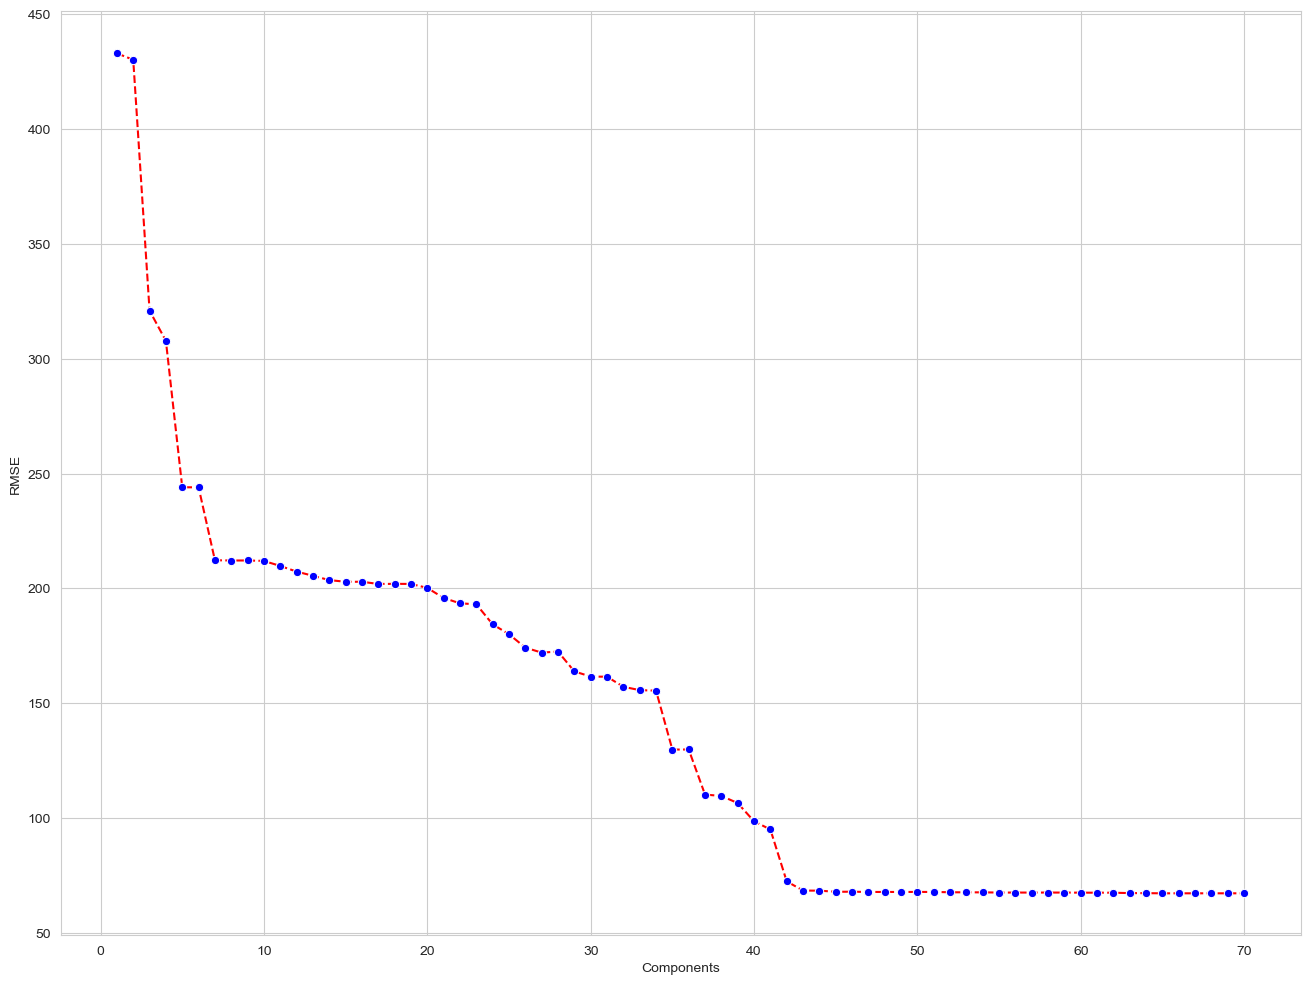

In [103]:
plt.figure(figsize=(16,12))
sbn.lineplot(x=lst_ncomponent,y=lst_rmse,marker='o',markerfacecolor='blue',color='red', linestyle='dashed')
plt.xlabel("Components")
plt.ylabel("RMSE")
plt.savefig("PCA graph_st.png")

##### From above graph it is clear that from n component 43 onwards RMSE remains the fairly constant low.So we will select 43 as our n components

In [104]:
pca=PCA(n_components=43)
x_train_pc_st=pca.fit_transform(x_train_st_scaled)
x_test_pc_st=pca.transform(x_test_st_scaled)

In [105]:
# defining hyper parameters to tune in
hyper_param={'alpha':[0,1,0.1,0.01,0.001,0.02,0.02,0.05,0.5,10,20,30,40,50,60],
            'l1_ratio':[0,0.01,0.02,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

In [106]:
elnet=ElasticNet()

# Using Gridsearch to find best parameters
gscv_1=GridSearchCV(estimator=elnet,param_grid=hyper_param,scoring='neg_mean_squared_error',cv=5,n_jobs=4)
gscv_1.fit(x_train_pc_st,y_train_st)

GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=4,
             param_grid={'alpha': [0, 1, 0.1, 0.01, 0.001, 0.02, 0.02, 0.05,
                                   0.5, 10, 20, 30, 40, 50, 60],
                         'l1_ratio': [0, 0.01, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5,
                                      0.6, 0.7, 0.8, 0.9, 1]},
             scoring='neg_mean_squared_error')

In [107]:
print(gscv_1.best_params_)
print(gscv_1.best_score_)

{'alpha': 0, 'l1_ratio': 0}
-4307.872758197364


In [108]:

# we will create an instance with best parameter with the best parameters
elnet_1=ElasticNet(**gscv_1.best_params_)
# Will fit the data
elnet_1.fit(x_train_pc_st,y_train_st)
# we will get our predictions
pred_train_st=elnet_1.predict(x_test_pc_st)
# we will calculate rmse
rmse_1=np.sqrt(mean_squared_error(pred_train_st,y_test_st))



In [109]:
print(rmse_1)

68.50600523241509


In [110]:
# will will check our r2 score
r2_score_st=elnet_1.score(x_train_pc_st,y_train_st)
print(r2_score_st)

0.988369421534462


In [111]:
#lets see if we get simillar r2 adjusted

x2=sm.add_constant(x_train_pc_st)
sts1=sm.OLS(y_train_st,x2)
sts2=sts1.fit()
print(sts2.summary())

                            OLS Regression Results                            
Dep. Variable:       hc_mortgage_mean   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 5.359e+04
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        23:51:24   Log-Likelihood:            -1.5194e+05
No. Observations:               27161   AIC:                         3.040e+05
Df Residuals:                   27117   BIC:                         3.043e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1625.0321      0.395   4113.518      0.0

# Consclusion: 

## 1. Our model has performed slightly better on city level dataset than national level dataset. 
## 2. Alpha and l1 ration for both the models were zero implying the most suitable model was simple liner regression
